## Setup

Import TensorFlow and other necessary libraries:

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import glob


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset
This demo will use a dataset of 6,837 photos of Pokemons. The dataset contains 150 subdirectories (one for each Pokemon) with around 20 - 50 images for each Pokemon:

```
PokemonData/
  Abra/
  Aerodactyl/
  Alakazam/
  Alolan Sandslash/
  Arbook/
```

You should now have a copy of the dataset available. There are 6,837 total images:

In [28]:
data_dir= pathlib.Path('/opt/app-root/src/pokedex-demo/database/PokemonData/')
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

6837


A wild Eevee appeared!:

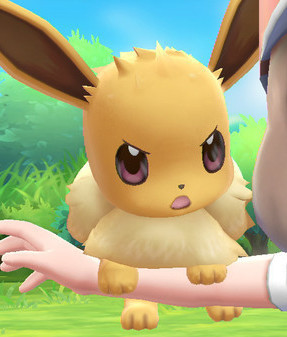

In [30]:
eevee = list(data_dir.glob('Eevee/*'))
PIL.Image.open(str(eevee[0]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code.

## Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6820 files belonging to 150 classes.
Using 5456 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6820 files belonging to 150 classes.
Using 1364 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [13]:
class_names = train_ds.class_names
print(class_names)

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Ni

## Visualize the data

Here are the first nine images from the training dataset:

2023-05-04 14:30:04.353637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


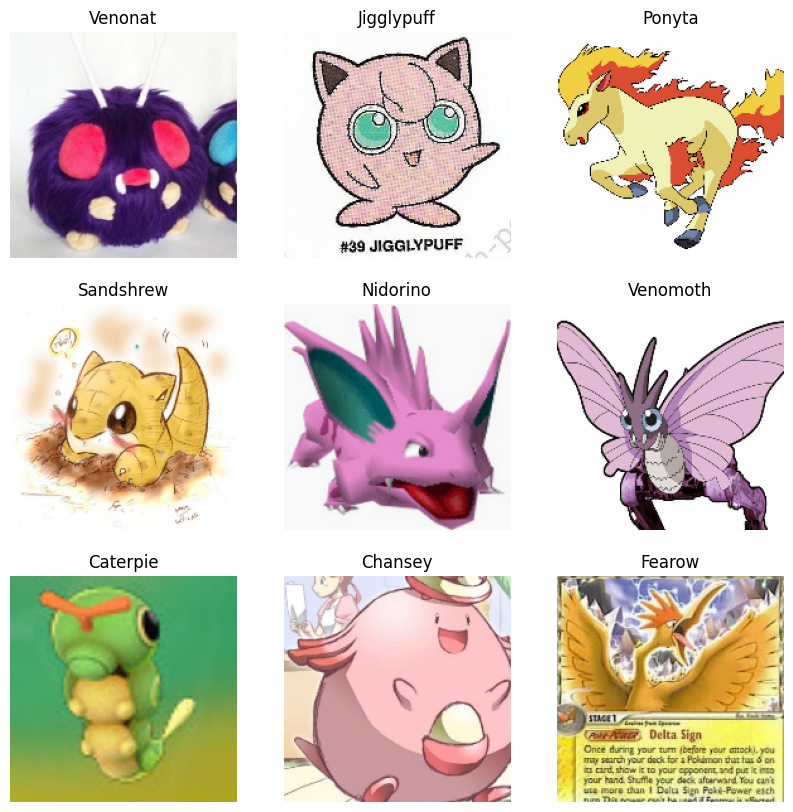

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras Model.fit method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [33]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.
Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [35]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:

In [36]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [37]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [ ]:
model.summary()

## Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [40]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
171/171 [==============================] - 158s 921ms/step - loss: 4.7578 - accuracy: 0.0213 - val_loss: 4.3369 - val_accuracy: 0.0535
Epoch 2/10
171/171 [==============================] - 154s 902ms/step - loss: 3.8796 - accuracy: 0.1261 - val_loss: 3.6372 - val_accuracy: 0.1562
Epoch 3/10
171/171 [==============================] - 154s 902ms/step - loss: 2.7548 - accuracy: 0.3360 - val_loss: 2.9974 - val_accuracy: 0.2669
Epoch 4/10
171/171 [==============================] - 155s 908ms/step - loss: 1.6601 - accuracy: 0.5748 - val_loss: 3.0895 - val_accuracy: 0.3248
Epoch 5/10
171/171 [==============================] - 156s 913ms/step - loss: 0.9036 - accuracy: 0.7625 - val_loss: 3.4601 - val_accuracy: 0.3321
Epoch 6/10
171/171 [==============================] - 155s 904ms/step - loss: 0.4179 - accuracy: 0.8849 - val_loss: 4.5053 - val_accuracy: 0.3358
Epoch 7/10
171/171 [==============================] - 155s 909ms/step - loss: 0.2412 - accuracy: 0.9382 - val_loss: 4.9337 -

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

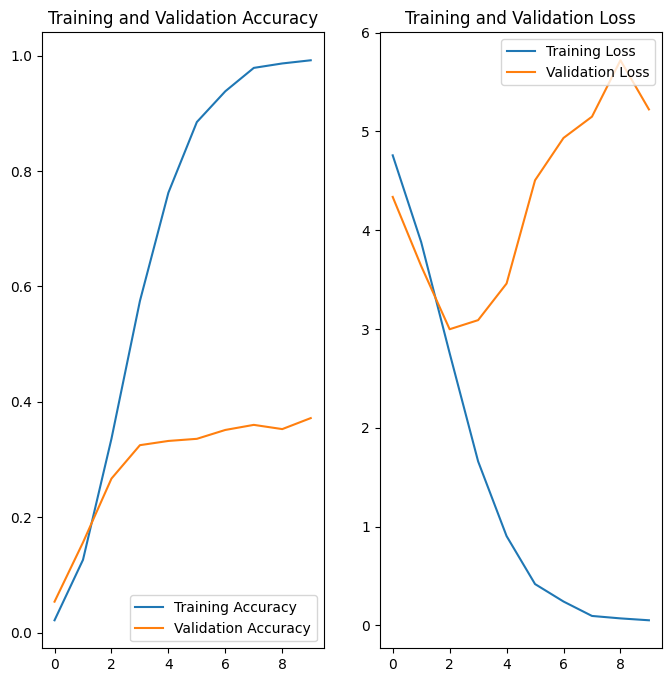

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

1/1 [==============================] - 0s 28ms/step
This image most likely belongs to Pikachu with a 92.62 percent confidence.


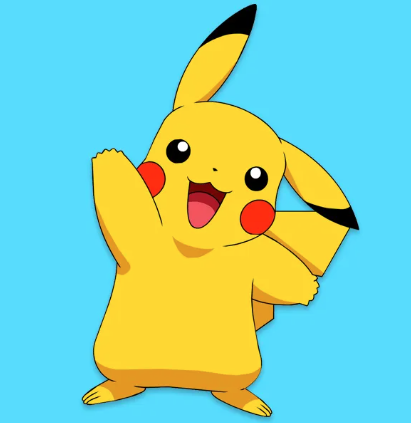

In [46]:
pokemon_path = data_dir= pathlib.Path('/opt/app-root/src/pokedex-demo/database/Predictions/pokemon.png')

img = tf.keras.utils.load_img(
    pokemon_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(str(pokemon_path))

In [47]:
pip install opencv-python-headless


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2
# Read each video frame by frame
video_path = '/opt/app-root/src/pokedex-demo/database/Predictions/pokemon.mp4'

src = cv2.VideoCapture(str(video_path))

ret, frame = src.read()
count = 0
success = True

while success:
    success,frame = src.read()
    if success:
        cv2.imwrite("frame%d.png" % count, frame)
        path = "frame%d.png" % count
        print(str(path))
        frame = tf.keras.utils.load_img(
        path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.utils.img_to_array(frame)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence.".
            format(class_names[np.argmax(score)], 100 * np.max(score))
        )
    else:
        print('End')

frame0.png
1/1 [==============================] - 0s 26ms/step
This image most likely belongs to Gyarados with a 69.84 percent confidence.
frame0.png
1/1 [==============================] - 0s 30ms/step
This image most likely belongs to Gyarados with a 69.91 percent confidence.
frame0.png
1/1 [==============================] - 0s 29ms/step
This image most likely belongs to Gyarados with a 69.77 percent confidence.
frame0.png
1/1 [==============================] - 0s 26ms/step
This image most likely belongs to Gyarados with a 69.71 percent confidence.
frame0.png
1/1 [==============================] - 0s 29ms/step
This image most likely belongs to Gyarados with a 69.62 percent confidence.
frame0.png
1/1 [==============================] - 0s 33ms/step
This image most likely belongs to Gyarados with a 69.72 percent confidence.
frame0.png
1/1 [==============================] - 0s 30ms/step
This image most likely belongs to Gyarados with a 69.65 percent confidence.
frame0.png
1/1 [===========